# Отток клиентов банка

---
### Задача

--- 

Необходимо спрогнозировать, уйдет клиент из банка в ближайшее время или нет.

### Данные

---

В нашем распоряжении есть данные, которые содержат информацию о клиентах банка, в том числе факт их ухода.

Источник данных: https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling

Описание данных:
- `RowNumber` - номер строки в данных;
- `CustomerId` - идентификатор клиента;
- `Surname` - фамилия;
- `CreditScore` - кредитный рейтинг;
- `Geography` - страна проживания;
- `Gender` - пол;
- `Age` - возраст;
- `Tenure` - сколько лет человек является клиентом банка;
- `Balance` - баланс на счете;
- `NumOfProducts` - количество продуктов банка, используемых клиентом;
- `HasCrCard` - наличие кредитной карты;
- `IsActiveMember` - активность клиента;
- `EstimatedSalary` - предполагаемая зарплата;
- `Exited` - **целевой признак**, факт ухода из банка.

### План проекта:

---

1. Предобработка данных.
    - Знакомство с данными, поиск проблем в данных (дубликатов, пропусков, выбросов). Построение гистограмм и матрицы корреляции. Предобработка.
2. Обучение моделей.
    - Подготовка признаков для обучения. Обучение моделей: логистическая регрессия, случайный лес, градиентные бустинги LGBM и CatBoost. Подбор гиперпараметров и оценка качества модели. В качестве основной метрики - F1, также считаем AUC-ROC (желательно добиться качества модели *F1=0.59*). Проверка лучшей модели на тесте, сравнение со случайной моделью.
3. Вывод.

---

## Предобработка данных

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
RANDOM_STATE = 42

In [3]:
data = pd.read_csv("../datasets/Churn_Modelling.csv")

### Знакомство с данными
Посмотрим на общую информацию о датасете.

In [4]:
def general_info(data):
    display(data.head())
    print(data.info())
    print('\nЯвных дубликатов:', data.duplicated().sum())
    
    data.hist(figsize=(12, 12), rwidth=0.9)
    plt.show()
    
    display(data.describe())
    
    _, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.1f', annot_kws={"fontsize": 12}, ax=ax)
    plt.show()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Явных дубликатов: 0


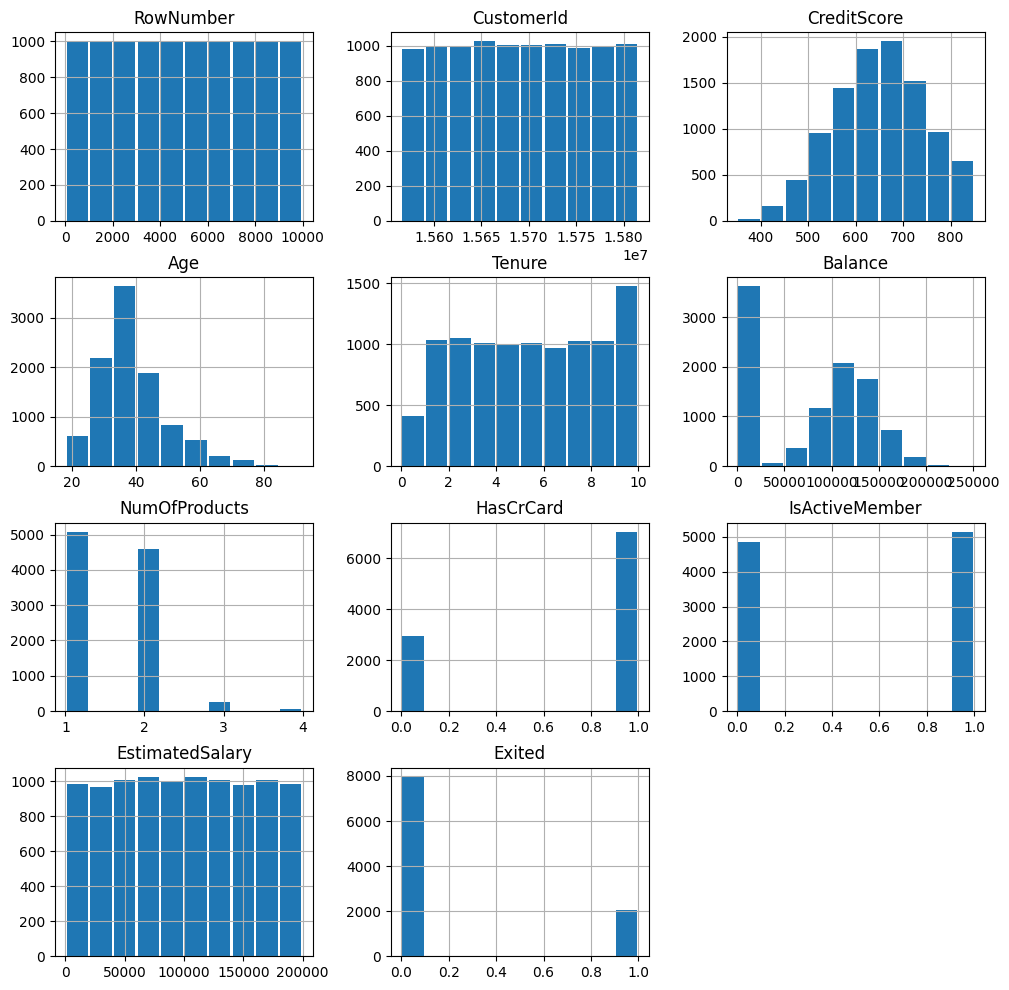

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


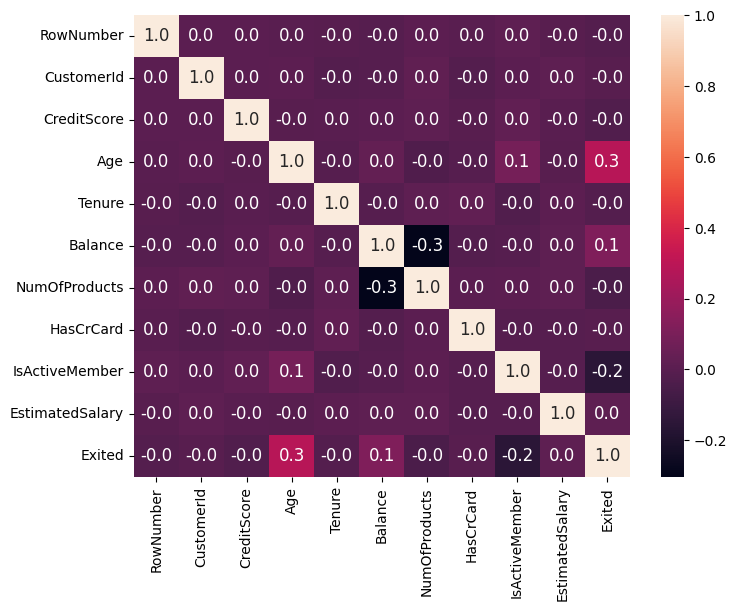

In [5]:
general_info(data)

**Промежуточный вывод:**

Датасет содержит 10 000 объектов и 14 признаков, включая целевой.

Пропусков и явных дубликатов нет, сильно коррелирующих числовых признаков тоже. Аномальные значения на первый взгляд также отсутствуют. Есть пара неинформативных признаков, которые стоит удалить: номер строки, id и фамилию клиента. Также для удобства можно привести названия столбцов к "змеиному" регистру.

Что нужно сделать:
- переименовать столбцы
- избавиться от лишних признаков

Стоит обратить внимание на наличие **дисбаланса** классов. Это нужно будет учесть при обучении и оценке качества моделей.

### Предобработка
Удалим неинформативные столбцы

In [6]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Переименуем столбцы

In [7]:
def camel_to_snake(name):
    """Перевод в змеиный регистр: 'ColName' --> 'col_name'"""
    return re.sub('([a-z])([A-Z])', ('\g<1>_\g<2>'), name).lower()

data.columns = [camel_to_snake(col) for col in data.columns]
data.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

## Обучение моделей

### Подготовка к обучению

**1)** Разделим данные на обучающую и тестовую подвыборки в соотношении 75:25 с учетом стратификации.

In [8]:
X, y = data.drop('exited', axis=1), data['exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

In [9]:
print('Размеры выборок:')
print(f'train - {len(X_train)} - {len(X_train)/len(data):.0%}')
print(f'test - {len(X_test)} - {len(X_test)/len(data):.0%}')
print()
print('Баланс классов:')
print(f"train - '0':'1' = {1 - y_train.mean():.2} : {y_train.mean():.2}")
print(f"test - '0':'1' = {1 - y_test.mean():.2} : {y_test.mean():.2}")

Размеры выборок:
train - 7500 - 75%
test - 2500 - 25%

Баланс классов:
train - '0':'1' = 0.8 : 0.2
test - '0':'1' = 0.8 : 0.2


**2)** Напишем ColomnTransformer'ы для линейных и 'деревянных' моделей. Для линейных моделей важно отмасштабировать числовые признаки и закодировать категориальные OneHotEncoder'ом, а для 'деревянных' моделей достаточно OrdinalEncoder'а для категориальных признаков.

In [10]:
num_features = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
cat_features = ['geography', 'gender', 'has_cr_card', 'is_active_member']

tree_transformer = ColumnTransformer(
    [("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_features)],
    remainder='passthrough'
)

linear_transformer = ColumnTransformer(
            [("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), cat_features),
            ("scaler", StandardScaler(), num_features)],
            remainder='passthrough'
)

**3)** Напишем функцию для обучения моделей с поиском гиперпараметров через GridSearchCV. Функция выводит лучшую метрику и гиперпараметры и возвращает лучшую модель.

При кросс-валидации нужно учесть соотношение классов, поэтому используем стратификацию. Так как перед нами стоит задача классификации с дисбалансом классов, то в качестве метрики будем использовать F1. Также дополнительно будем оценивать метрику AUC-ROC.

In [11]:
def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(
        estimator=estimator, 
        param_grid=param_grid, 
        n_jobs=-1, 
        cv=StratifiedKFold(4, shuffle=True, random_state=RANDOM_STATE),
        scoring = ['roc_auc','f1'],
        refit='f1'
    )

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_roc_auc = round(model.cv_results_['mean_test_roc_auc'][best_index], 2)
    best_f1_score = round(model.cv_results_['mean_test_f1'][best_index], 2)

    print(f"Best F1: {best_f1_score}, AUC-ROC: {best_roc_auc}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

### Logistic Regression

In [12]:
logreg_estimator = Pipeline([
    ('linear_transformer', linear_transformer),
    ('logreg', LogisticRegression(solver='newton-cholesky', n_jobs=-1, random_state=RANDOM_STATE)),
])

logreg_param = {'logreg__class_weight':['balanced', None]}

logreg_best = fit_model(
    estimator=logreg_estimator,
    param_grid=logreg_param,
    X_train=X_train,
    y_train=y_train
)

Best F1: 0.48, AUC-ROC: 0.76
Best params: {'logreg__class_weight': 'balanced'}


### Random Forest

In [13]:
%%time
rf_estimator = Pipeline([
    ('tree_transformer', tree_transformer),
    ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)),
])

rf_param = {
    'rf__n_estimators': range(70, 131, 15),
    'rf__max_depth': range(4, 15, 2),
}

rf_best = fit_model(
    estimator=rf_estimator,
    param_grid=rf_param,
    X_train=X_train,
    y_train=y_train
)

Best F1: 0.61, AUC-ROC: 0.85
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 100}
CPU times: total: 2.06 s
Wall time: 20.1 s


### LGBMClassifier

In [14]:
%%time
lgbm_estimator = Pipeline([
    ('tree_transformer', tree_transformer),
    ('lgbm', LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)),
])

lgbm_param = {
    "lgbm__n_estimators": range(50, 151, 25), 
    "lgbm__max_depth": range(3, 15, 2),
    'lgbm__learning_rate': [0.01, 0.1],
}

lgbm_best = fit_model(
    estimator=lgbm_estimator,
    param_grid=lgbm_param,
    X_train=X_train,
    y_train=y_train
)

Best F1: 0.61, AUC-ROC: 0.85
Best params: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 100}
CPU times: total: 3.22 s
Wall time: 29.1 s


### CatBoostClassifier

In [15]:
%%time
catboost_estimator = CatBoostClassifier(
    cat_features=cat_features,
    early_stopping_rounds=20,
    auto_class_weights='Balanced',
    random_state=RANDOM_STATE,
    verbose=False,
)

catboost_param = {
    "iterations": range(150, 301, 25), 
    "learning_rate": [0.05, 0.1, 0.15],
    "depth": range(2, 9, 2),
}

catboost_best = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param,
    X_train=X_train,
    y_train=y_train
)

Best F1: 0.62, AUC-ROC: 0.86
Best params: {'depth': 6, 'iterations': 250, 'learning_rate': 0.05}
CPU times: total: 26.5 s
Wall time: 7min 53s


### Анализ моделей

Лучшей моделью оказалась модель CatBoost с метриками F1=0.62 и AUC-ROC=0.86. Параметры модели: depth=6, iterations=250, learning_rate=0.05.

Проверим качество модели на тестовой выборке.

In [16]:
score = f1_score(y_test, catboost_best.predict(X_test)) 
print(f"Качество на тесте: F1={score:.2}")

Качество на тесте: F1=0.63


В итоге у нас получилось добиться желаемого качества модели.

Сравним ROC-кривые и AUC-ROC лучшей модели с остальными.

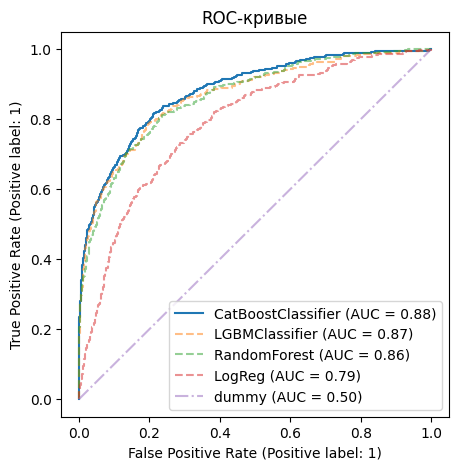

In [17]:
_, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_estimator(catboost_best, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(lgbm_best, X_test, y_test, ax=ax, name="LGBMClassifier", alpha=0.5, linestyle="--")
RocCurveDisplay.from_estimator(rf_best, X_test, y_test, ax=ax, name="RandomForest", alpha=0.5, linestyle="--")
RocCurveDisplay.from_estimator(logreg_best, X_test, y_test, ax=ax, name="LogReg", alpha=0.5, linestyle="--")
RocCurveDisplay.from_estimator(DummyClassifier().fit(X_train, y_train), X_test, y_test, ax=ax, name="dummy", alpha=0.5, linestyle='-.')
ax.set_title("ROC-кривые")
plt.show()

Судя по графику, ансамблевые методы над деревьями примерно одинаково справляются с предсказаниями, но CatBoost все же немного лучше. Также мы видим, что все модели лучше случайной.

## Вывод

Перед нами стояла задача построить модель для прогнозирования ухода клиента из банка. 

В нашем распоряжении были исторические данные о клиентах банка и факте их ухода. Размер выборки - 10 000 объектов, 10 информативных признаков и один целевой категориальный. Выборка несбалансирована: отношение положительного класса к отрицательному 20:80. Этот факт был учетн, и при обучении использовалось взвешивание классов, а для оценки качества модели была выбрана метрика F1.

Было обучено несколько моделей: логистическая регрессия, случайный лес, LGBM и CatBoost. Лучшее качество удалось получить для модели **CatBoost** с параметрами *depth=6, iterations=250, learning_rate=0.05* и метриками **F1=0.62** и AUC-ROC=0.86. Мы добились желаемого качества (минимум F1=0.59).